# Transformer

감정 분석 task에 RNN 대신 Transformer를 구현하여 적용

In [128]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [129]:
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from torch.nn.utils.rnn import pad_sequence
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
    max_len = 400
    texts, labels = [], []
    
    for row in batch:
        # 문자열 텍스트를 토큰화하고 ID로 변환
        tokens = tokenizer.encode(row['text'], add_special_tokens=True, truncation=True, max_length=max_len)

        if len(tokens) > 1:
            labels.append(tokens[-2])  # 마지막 단어의 ID를 레이블로 사용
            texts.append(tokens[:-2])   # 마지막 단어를 제외한 텍스트

    # 패딩 처리
    if texts:
        # 각 텍스트를 max_len으로 패딩 처리
        texts = pad_sequence([torch.tensor(t, dtype=torch.long)[:max_len] for t in texts], batch_first=True)
        labels = torch.tensor(labels, dtype=torch.long)  # 레이블도 LongTensor로 변환
    else:
        # 빈 배치의 경우 None 반환
        return None, None

    return texts, labels
    
# DataLoader에 대한 설정
train_loader = DataLoader(ds['train'], batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(ds['test'], batch_size=64, shuffle=False, collate_fn=collate_fn)

Using cache found in C:\Users\suzuk/.cache\torch\hub\huggingface_pytorch-transformers_main


In [130]:
from torch import nn
from math import sqrt


class MultiHeadAttention(nn.Module):
    #input_dim = 임베딩 차원 / d_model = q,k,v가 가질 차원의 크기
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()
    try:
        self.input_dim = input_dim
        self.d_prime_model = int(round(d_model/n_heads,0))
        self.n_heads = n_heads
    except round(d_model/n_heads,0) % n_heads is not 0:
        print('round(d_model/n_heads,0) % n_heads is not 0')
        
    self.wq = nn.Linear(input_dim, d_model) #쿼리벡터 생성
    self.wk = nn.Linear(input_dim, d_model) #키 벡터 생성
    self.wv = nn.Linear(input_dim, d_model) #밸류 벡터 생성
    self.dense = nn.Linear(d_model, d_model) #어텐션 최종 out 을 위해.
    self.softmax = nn.Softmax(dim=-1)
    

  def forward(self, x, mask):   
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    # B S H D' 에서 B H S D'으로 변경 필요
    # B S H D' 은 batch 안에 sequentioal가 key인 H vs D' 행렬이 존재하므로 Head가 종속적
    # B H S D'은 batch 안에 head가 key 인 S vs D' 행렬이 존재 하므로 Head가 독립적
    q = q.view(q.shape[0], q.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    k = k.view(k.shape[0], k.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)
    v = v.view(v.shape[0], v.shape[1], self.n_heads, self.d_prime_model).transpose(1,2)

    # B H S D' * B H D' S = B H S S
    # 각 head에 따른 상관도를 확인 가능
    score = torch.matmul(q, k.transpose(-1, -2)) 
    score = score / sqrt(self.d_prime_model)
    
    if mask is not None:
    #마스크가 있다면 실행, 마스크가 있는곳은 1로 되어져있으므로 가장 작은수를 곱하고 더함
    #soft max 함수 이후에 0에 근사함
    #mask(B S S) 와 현 score(B H S S) 텐서 형식이 다르므로 통일 해줘야함.
        mask = mask.unsqueeze(1)
    #unsqueeze를 통해 B 1 S S로 만듬
        score = score + (mask * -1e9)

    score = self.softmax(score) # B H S S
    result = torch.matmul(score, v) # B H S D'
    result = result.transpose(1,2).contiguous()
    result = result.view(result.shape[0], result.shape[1], -1) # B S D
    result = self.dense(result)
    return result

<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\suzuk\AppData\Local\Temp\ipykernel_1576\2979245485.py:13: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  except round(d_model/n_heads,0) % n_heads is not 0:


In [131]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff, dropout):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.MHA = MultiHeadAttention(input_dim, d_model, 4)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )
    self.dropout1 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정
    self.dropout2 = nn.Dropout(p=dropout)  # 적절한 p 값을 설정

    self.layer_norm1 = nn.LayerNorm(d_model)  # Layer Normalization 정의
    self.layer_norm2 = nn.LayerNorm(d_model)  # Layer Normalization 정의

  def forward(self, x, mask):
    x1 = self.MHA(x, mask)
    x1 = self.dropout1(x1)
    x1 = self.layer_norm1(x1 + x)

    x2 = self.ffn(x)
    x2 = self.dropout2(x2)
    x2 = self.layer_norm2(x2 + x1)

    return x2

In [132]:
import numpy as np

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


In [133]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, dff, dropout):
        super().__init__()

        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_layers = n_layers
        self.dff = dff

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = nn.Parameter(positional_encoding(400, d_model), requires_grad=False)  # max_len을 400으로 설정
        self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff, dropout) for _ in range(n_layers)])
        self.classification = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.shape[1]  # 동적으로 seq_len 설정
        mask = (x == tokenizer.pad_token_id)
        mask = mask[:, None, :]
        
        x = self.embedding(x)
        x = x * sqrt(self.d_model)

        # pos_encoding 크기를 seq_len에 맞게 조정
        pos_encoding = self.pos_encoding[:, :seq_len]
        x = x + pos_encoding

        for layer in self.layers:
            x = layer(x, mask)

        x = x[:, 0]  # 첫 번째 토큰에 대한 출력을 가져옵니다.
        x = self.classification(x)

        return x

In [134]:
from torch.optim import Adam

lr = 0.001
loss_fn = nn.CrossEntropyLoss()

In [135]:
import numpy as np
import matplotlib.pyplot as plt

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [136]:
train_acc_list = []
test_acc_list = []
#vocab_size, d_model, n_layers, dff, dropout
def train_and_test(n_epochs, dropout):
    model = TextClassifier(len(tokenizer), 128, 5, 512, dropout)
    model = model.to('cuda')
    optimizer = Adam(model.parameters(), lr=lr)
    
    n_epochs = n_epochs

    for epoch in range(n_epochs):
        total_loss = 0.
        model.train()
        
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            preds = model(inputs)
            loss = loss_fn(preds, labels) 
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
      
        print(f"Epoch {epoch:3d} | Train Loss: {total_loss/len(train_loader)}")
        
        with torch.no_grad():
            model.eval()
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)
            print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
            train_acc_list.append(train_acc*100)
            test_acc_list.append(test_acc*100)

In [137]:
import numpy as np
train_and_test(50, 0.4)

Epoch   0 | Train Loss: 3.5560460218688106
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   1 | Train Loss: 3.068231926549731
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   2 | Train Loss: 2.994969775914536
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   3 | Train Loss: 2.94641284473107
=========> Train acc: 0.558 | Test acc: 0.564
Epoch   4 | Train Loss: 2.7630850369363187
=========> Train acc: 0.557 | Test acc: 0.556
Epoch   5 | Train Loss: 2.704395614621584
=========> Train acc: 0.547 | Test acc: 0.546
Epoch   6 | Train Loss: 2.6633032563397343
=========> Train acc: 0.542 | Test acc: 0.532
Epoch   7 | Train Loss: 2.6424654359402866
=========> Train acc: 0.559 | Test acc: 0.549
Epoch   8 | Train Loss: 2.60858561925571
=========> Train acc: 0.555 | Test acc: 0.543
Epoch   9 | Train Loss: 2.5930990739856536
=========> Train acc: 0.556 | Test acc: 0.543
Epoch  10 | Train Loss: 2.5763313849563794
=========> Train acc: 0.555 | Test acc: 0.541
Epoch  11 | Train Loss: 2.55

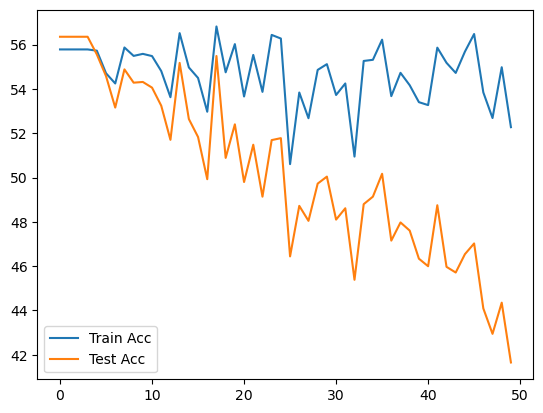

In [138]:
plt.plot(train_acc_list, label = 'Train Acc')
plt.plot(test_acc_list, label = 'Test Acc')
plt.legend()
plt.show()